In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import scipy.cluster.hierarchy as sch

# Load data
df = pd.read_csv('../../Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [9]:
df = df.drop('CustomerID', axis=1)
df['Genre'] = df['Genre'].map({'Male': 0, 'Female': 1})
X = df.iloc[:, [1, 2, 3]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

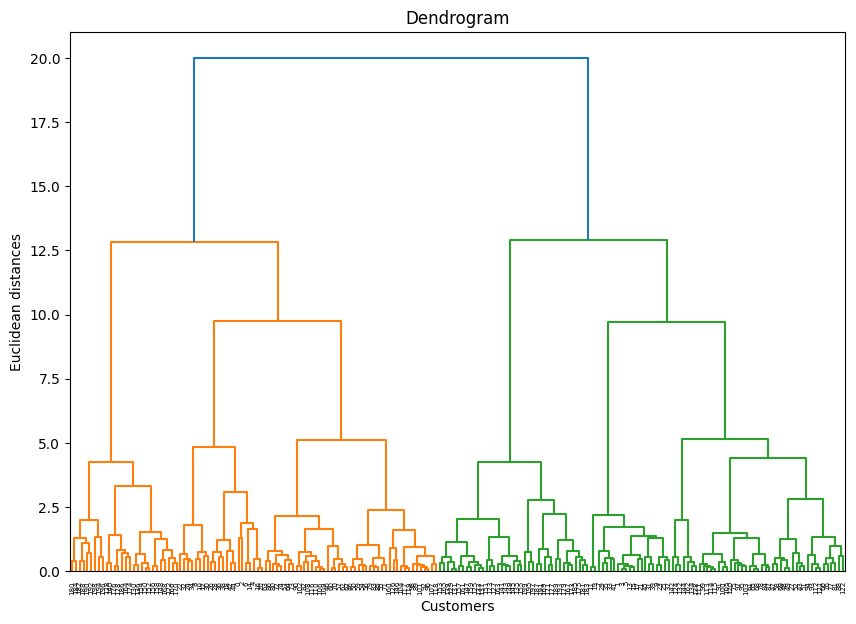

In [10]:
# Dendrogram (Using scipy for visualization guidance)
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [11]:
class AgglomerativeClusteringScratch:
    def __init__(self, n_clusters=2, linkage='complete'):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.labels_ = None

    def fit_predict(self, X):
        n_samples = X.shape[0]
        clusters = [[i] for i in range(n_samples)]
        dist_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                d = np.linalg.norm(X[i] - X[j])
                dist_matrix[i, j] = d
                dist_matrix[j, i] = d
        np.fill_diagonal(dist_matrix, np.inf)
        active_indices = list(range(n_samples))
        while len(active_indices) > self.n_clusters:
            min_dist = np.inf
            merge_pair = (-1, -1)
            for i_idx in range(len(active_indices)):
                i = active_indices[i_idx]
                for j_idx in range(i_idx + 1, len(active_indices)):
                    j = active_indices[j_idx]
                    if dist_matrix[i, j] < min_dist:
                        min_dist = dist_matrix[i, j]
                        merge_pair = (i, j)
            
            c1, c2 = merge_pair
            clusters[c1].extend(clusters[c2])
            for k in active_indices:
                if k != c1 and k != c2:
                    d1 = dist_matrix[c1, k]
                    d2 = dist_matrix[c2, k]
                    if self.linkage == 'complete':
                        new_dist = max(d1, d2)
                    elif self.linkage == 'single':
                        new_dist = min(d1, d2)
                    elif self.linkage == 'average':
                        new_dist = (d1 + d2) / 2 
                    else:
                        new_dist = max(d1, d2)   
                    dist_matrix[c1, k] = new_dist
                    dist_matrix[k, c1] = new_dist
            active_indices.remove(c2)
        

        self.labels_ = np.zeros(n_samples, dtype=int)
        for label_id, cluster_indices in enumerate(active_indices):
            for idx in clusters[cluster_indices]:
                self.labels_[idx] = label_id
                
        return self.labels_

In [12]:
# Tuning Loop
best_k = -1
best_linkage = ''
best_sil = -1
best_db = float('inf')
results = []

print("Tuning Hierarchical Clustering Parameters:")
print(f"{'k':<5} {'Linkage':<10} {'Silhouette':<15} {'Davies-Bouldin':<15}")

for k in range(2, 11):
    for linkage in ['complete', 'single', 'average']:
        hc = AgglomerativeClusteringScratch(n_clusters=k, linkage=linkage)
        labels = hc.fit_predict(X_scaled)
        
        # Agglomerative can sometimes produce singletons if k is large/linkage is single
        if len(np.unique(labels)) < 2:
             continue
             
        sil_score = silhouette_score(X_scaled, labels)
        db_score = davies_bouldin_score(X_scaled, labels)
        
        # Store results
        results.append((k, linkage, sil_score, db_score))
        print(f"{k:<5} {linkage:<10} {sil_score:<15.4f} {db_score:<15.4f}")
        
        if sil_score > best_sil:
            best_sil = sil_score
            best_db = db_score
            best_k = k
            best_linkage = linkage

print(f"\nBest Configuration: k={best_k}, linkage='{best_linkage}'")
print(f"Best Silhouette Score: {best_sil:.4f}")
print(f"Davies-Bouldin Score: {best_db:.4f}")

# Fit final model
hc_final = AgglomerativeClusteringScratch(n_clusters=best_k, linkage=best_linkage)
labels = hc_final.fit_predict(X_scaled)

Tuning Hierarchical Clustering Parameters:
k     Linkage    Silhouette      Davies-Bouldin 
2     complete   0.2330          1.7943         
2     single     0.2514          0.5802         
2     average    0.2277          1.7500         
3     complete   0.2838          1.3358         
3     single     0.1611          0.5514         
3     average    0.2486          1.1719         
4     complete   0.3901          0.9266         
4     single     0.0425          0.6158         
4     average    0.3242          1.1452         
5     complete   0.4000          0.8848         
5     single     0.0030          0.6288         
5     average    0.3062          1.0606         
6     complete   0.3746          1.0005         
6     single     -0.0428         0.6370         
6     average    0.2919          1.0512         
7     complete   0.3434          1.1308         
7     single     -0.0459         0.6723         
7     average    0.3180          0.9704         
8     complete   0.3714   

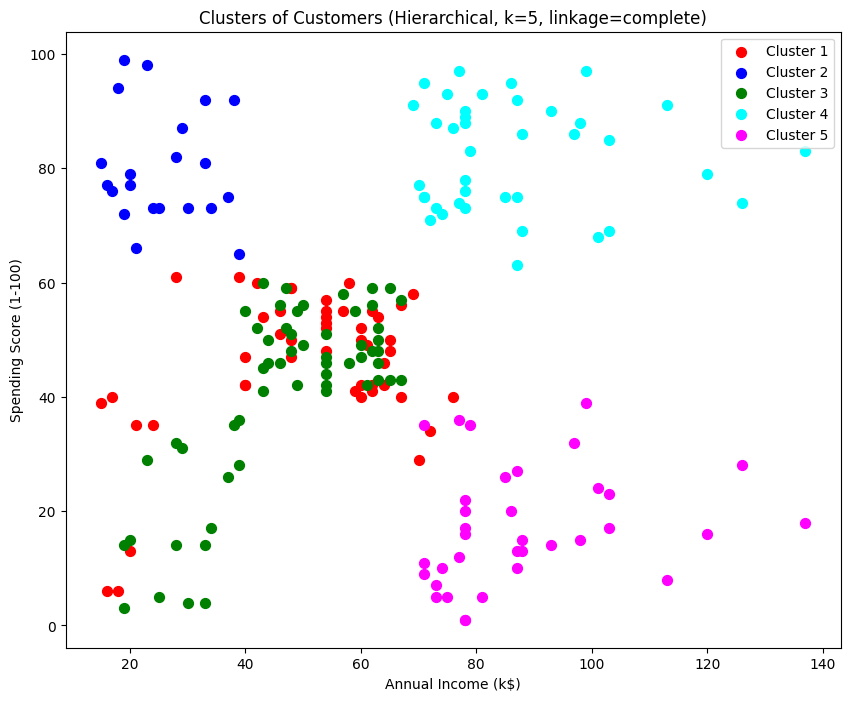

In [13]:
# Visualization
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'cyan', 'magenta', 'orange', 'purple', 'brown', 'pink', 'gray']

for i in range(best_k):
    plt.scatter(X[labels == i, 1], X[labels == i, 2], s=50, c=colors[i % len(colors)], label=f'Cluster {i+1}')

plt.title(f'Clusters of Customers (Hierarchical, k={best_k}, linkage={best_linkage})')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()